In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json
import os
import pickle
import re

#from src.visualizations.additional_plotting_functions import loss_archetype_plot, NMI_archetypes, plot_NMI_stability

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Plots for paper

In [31]:
my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C","GT": "#9055A2"}

In [4]:


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    """
    Function that loads results from a given analysis.
    The format is a nested dictionary on the form results[AA_method][n_archetypes][repetition_num]
    The result objects saved have all matrices and parameters inside them. E
    """

    folder = f'C:/Users/aejew/Downloads/AA_results/AA_results/{analysis_dir}'

    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}



    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = re.sub('[^0-9]', '', file.split('_')[1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj
    return results


# NAIVE DATA 

In [5]:
naive_res= load_analyses("1000_respondents_noRB_results")
naive_cor = load_analyses("1000_respondents_noRB_corrupted_results")
naive_osm = load_analyses("no_RB_OSM")
naive_osm_corr = load_analyses("no_RB_OSM_corrupted")

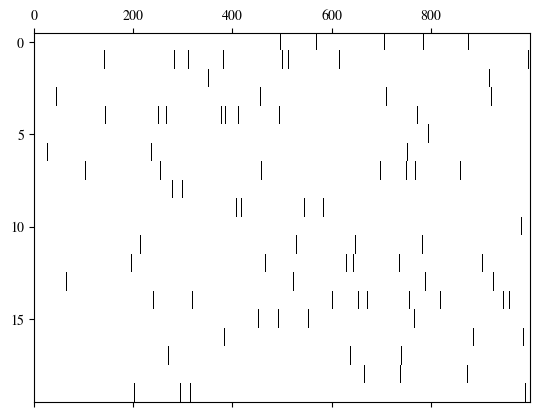

In [6]:
X = naive_res['RBOAA']['K1'][3].X
X_osm = naive_osm['TSAA']['K1'][3].X
X_cor = naive_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)

In [7]:

import torch
def _calculate_probRBOAA(Xt,X_hat,b,sigma):
        z_next = (torch.gather(b,1,Xt)-X_hat)/sigma#[:,None]
        z_prev = (torch.gather(b,1,Xt-1)-X_hat)/sigma #[:,None]
        z_next[Xt == len(b[0,:])+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev
        

def _calculate_probOAA(Xt, X_hat, b, sigma):
        z_next = (b[Xt] - X_hat)/sigma
        z_prev = (b[Xt-1] - X_hat)/sigma
        z_next[Xt == len(b)+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev

        
def findProb(data,method, i, j, p):
    
    X_hat = torch.tensor(data[method][f'K{i}'][j].X_hat)
    Prob = torch.zeros(X_hat.shape)
    b = torch.tensor(data[method][f'K{i}'][j].b)
    sigma = torch.tensor(data[method][f'K{i}'][j].sigma)
    R_est = torch.zeros(X.shape)

    #sigma = torch.tensor(naive_cor['OAA'][f'K{i}'][j].sigma)
    #sigmaRBOAA = torch.tensor(naive_cor['RBOAA'][f'K{i}'][j].sigma)

    #betaOAA = torch.tensor(naive_cor['OAA'][f'K{i}'][j].b)
    #betaRBOAA = torch.tensor(naive_cor['RBOAA'][f'K{i}'][j].b)

    #sigma_test = sigma.repeat(sigmaRBOAA.shape)
    #beta_test = betaOAA.repeat(betaRBOAA.shape)

    #X_hat = torch.tensor(naive_cor['OAA'][f'K{i}'][j].X_hat)


    for l in p:
        Xt = torch.ones(X_hat.shape,dtype = int)*(int(l))

        if method == 'OAA':
            Prob = _calculate_probOAA(Xt, X_hat, b, sigma)

        elif method == 'RBOAA':
            Prob =  _calculate_probRBOAA(Xt,X_hat,b,sigma.T)
                
        R_est += Prob*l


    return R_est






In [8]:
p = [1,2,3,4,5]

R_corr_CAA = np.zeros((11,10),dtype= object)
R_corr_RBOAA = np.zeros((11,10),dtype= object)
R_corr_OAA = np.zeros((11,10),dtype= object)
R_corr_TSOAA = np.zeros((11,10),dtype= object)

for i in range(1,11): 
    for j in range(10):

        R_estRBOAA = findProb(naive_cor,'RBOAA', i, j, p)
        R_estOAA = findProb(naive_cor,'OAA', i, j, p)


        R_corr_CAA[i,j] = naive_cor['CAA']['K1'][3].X@naive_cor['CAA'][f'K{i}'][j].B@naive_cor['CAA'][f'K{i}'][j].A
        R_corr_OAA[i,j] = R_estOAA.numpy() #naive_cor['OAA']['K1'][3].X@naive_cor['OAA'][f'K{i}'][j].B@naive_cor['OAA'][f'K{i}'][j].A
        R_corr_RBOAA[i,j] = R_estRBOAA.numpy() #naive_cor['RBOAA']['K1'][3].X@naive_cor['RBOAA'][f'K{i}'][j].B@naive_cor['RBOAA'][f'K{i}'][j].A
        R_corr_TSOAA[i,j] = naive_cor['CAA']['K1'][3].X@naive_osm_corr['TSAA'][f'K{i}'][j].B@naive_osm_corr['TSAA'][f'K{i}'][j].A

In [9]:
X.shape

(20, 1000)

In [10]:
SSE_CAA = np.zeros((11,10))
SSE_RBOAA = np.zeros((11,10))
SSE_OAA = np.zeros((11,10))
SSE_TSOAA = np.zeros((11,10))

for i in range(1,11):
    for j in range(10):
        SSE_CAA[i,j] = np.sqrt(((X[idx]- R_corr_CAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_OAA[i,j] = np.sqrt(((X[idx]- R_corr_OAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_RBOAA[i,j] = np.sqrt(((X[idx]- R_corr_RBOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_TSOAA[i,j] = np.sqrt(((X[idx]- R_corr_TSOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))


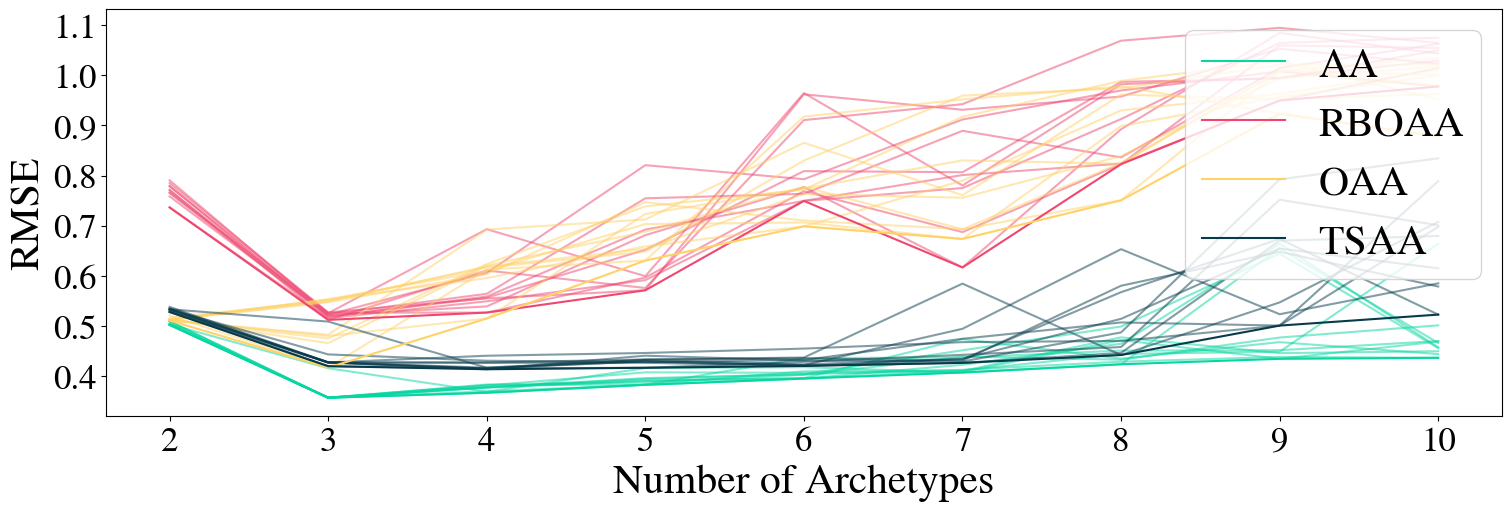

In [11]:




fig, ax = plt.subplots(1,1, figsize = (15,5), layout='constrained')
ax.plot(range(2,11), SSE_CAA[2:], c = my_pallette['AA'],alpha = 0.5)
ax.plot(range(2,11), SSE_RBOAA[2:],c = my_pallette['RBOAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_OAA[2:],c = my_pallette['OAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_TSOAA[2:],c = my_pallette['TSOAA'],alpha = 0.5)

ax.plot(range(2,11), np.min(SSE_CAA[2:],axis = 1), c = my_pallette['AA'],label = 'AA')
ax.plot(range(2,11), np.min(SSE_RBOAA[2:],axis = 1),c =  my_pallette['RBOAA'],label = 'RBOAA')
ax.plot(range(2,11), np.min(SSE_OAA[2:],axis = 1),c =  my_pallette['OAA'],label = 'OAA')
ax.plot(range(2,11), np.min(SSE_TSOAA[2:],axis = 1),c =  my_pallette['TSOAA'],label = 'TSAA')


ax.set_xlabel("Number of Archetypes", fontsize = 30)
ax.set_ylabel("RMSE", fontsize = 30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc='upper right',fontsize = 30)

plt.savefig("Plots_for_paper/CorruptionError_naive.png",dpi=1000)



OAA[7 6 8 5 4 3 2 1 0]
[1.35590195e+04 1.14582275e+03 4.61255585e+02 6.13253937e+01
 1.15326672e+01 9.91346169e+00 8.48638535e+00 6.61419678e+00
 8.86780739e+00]
RBOAA[8 7 6 5 3 2 1 4 0]
[7.94289795e+03 6.10561594e-02 3.46076749e-02 2.19558403e-02
 2.32123062e-01 1.47002842e-02 3.64015927e-03 3.50795244e-03
 3.26500251e-03]
AA[8 7 6 5 4 3 2 1 0]
[4692.79248047 1531.26977539 1384.60168457 1289.39855957 1208.27368164
 1132.40063477 1070.24304199 1006.62683105  951.51281738]
TSAA[8 7 6 5 4 3 2 1 0]
[6453.3515625  2305.85644531 2034.07800293 1803.08703613 1594.36682129
 1439.21362305 1333.02844238 1253.30871582 1148.62023926]


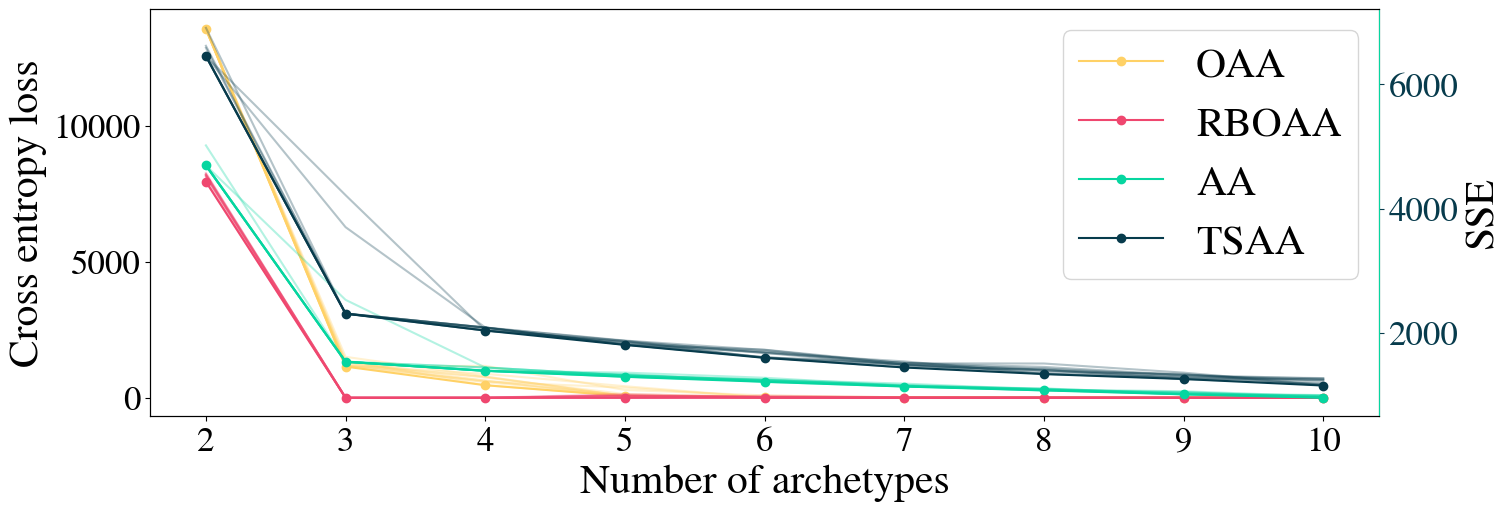

In [12]:
K_list = np.arange(2,11)
## Plot SSE
from src.visualizations. loss_archetype_plot import loss_archetype_plot

loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/1000_respondents_noRB_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_naive.png",dpi=1000)

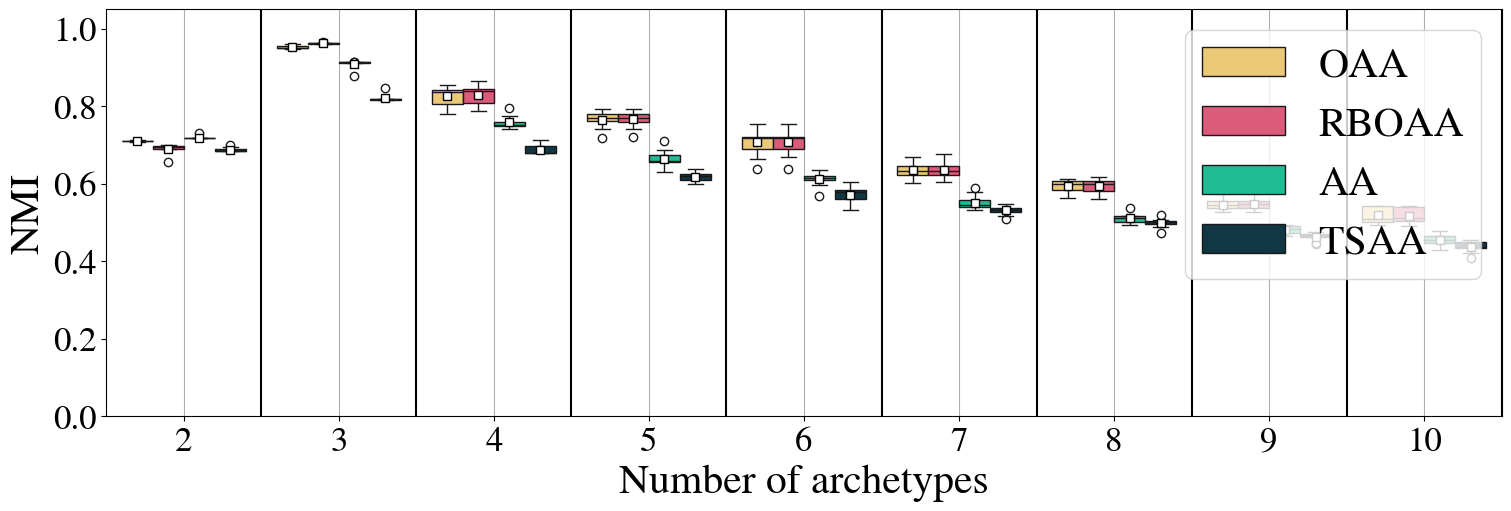

In [14]:
from src.visualizations. NMI_archetypes import NMI_archetypes

K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/1000_respondents_noRB_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_naive.png",dpi=1000)

# Complex Data

In [15]:
complex_res= load_analyses("complex_results")
complex_cor = load_analyses("complex_corrupted_results")
complex_osm = load_analyses("complex_OSM_results")
complex_osm_corr = load_analyses("complex_OSM_corrupted_results")

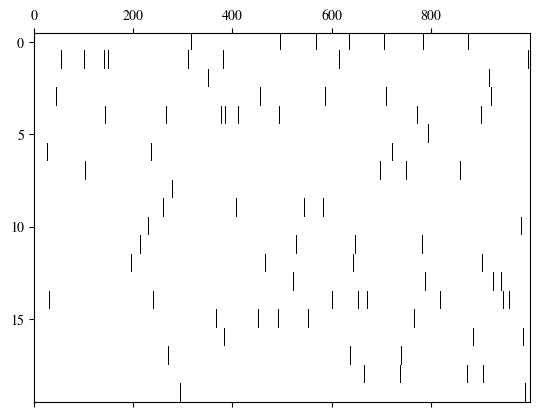

In [16]:
X = complex_res['RBOAA']['K1'][2].X
X_osm = complex_osm['TSAA']['K1'][3].X
X_cor = complex_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)



OAA[8 7 6 5 4 3 2 1 0]
[19904.61914062 15540.41992188 10807.14746094  7553.40625
  6802.43310547  5919.18066406  5281.10742188  4582.37011719
  3885.48632812]
RBOAA[8 7 6 5 4 2 1 3 0]
[6.07800928e+03 5.44738541e+01 5.86982727e-01 6.85633163e+01
 3.89244258e-01 3.58314008e-01 3.26829761e-01 2.81267047e-01
 2.45882362e-01]
AA[8 7 6 5 4 3 2 1 0]
[9575.61035156 6222.72070312 4178.64697266 2992.8684082  2700.76171875
 2404.86376953 2197.06274414 2057.43041992 1936.5760498 ]
TSAA[8 7 6 5 4 3 2 1 0]
[11261.23339844  7598.06591797  5262.81103516  3786.40039062
  3284.7668457   2955.49365234  2660.859375    2481.09179688
  2322.49462891]


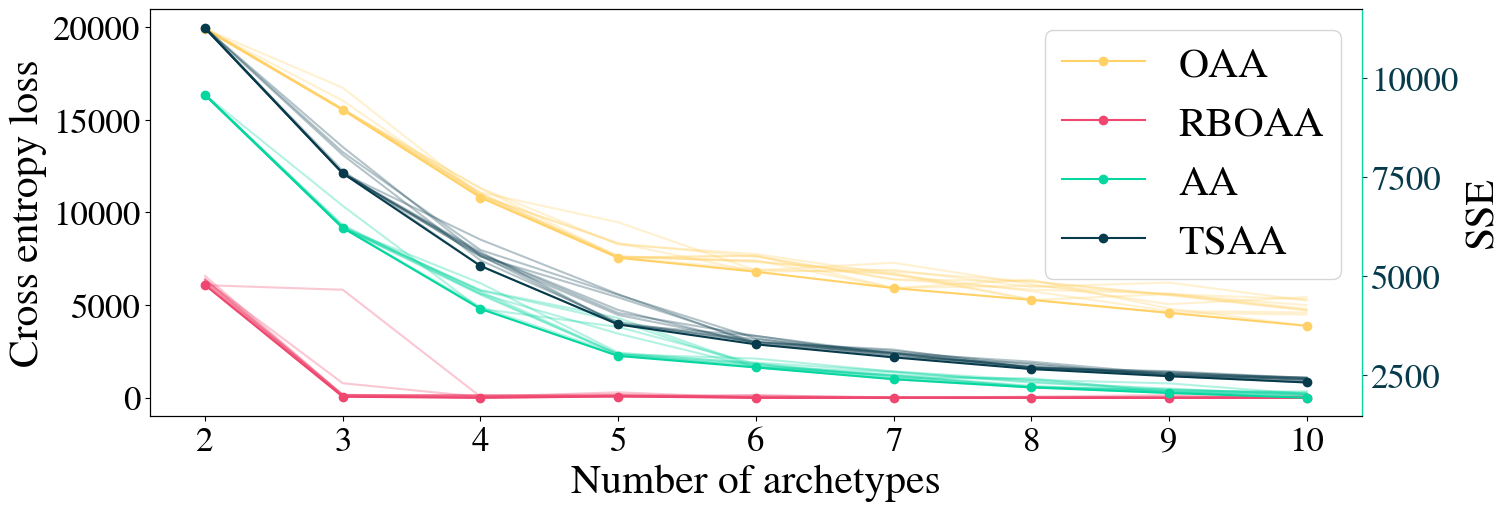

In [17]:
K_list = np.arange(2,11)
loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_OSM_results/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_complex.png",dpi=1000)

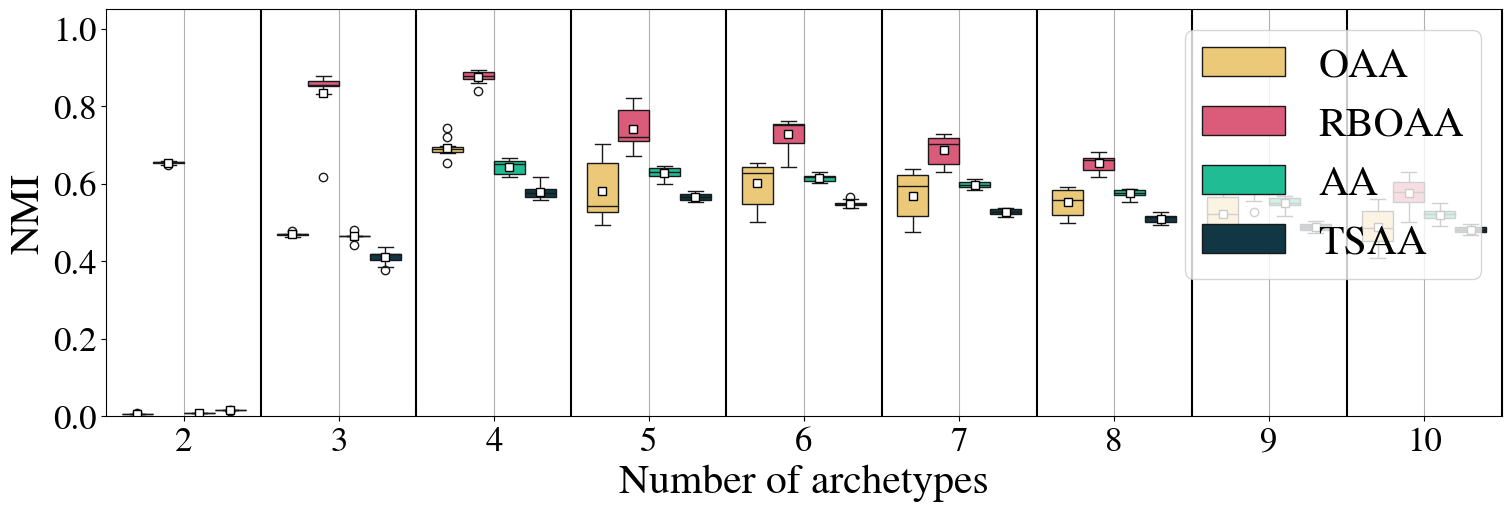

In [18]:
K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_OSM_results/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_complex.png",dpi=1000)

In [19]:
p = [1,2,3,4,5]

R_corr_CAA = np.zeros((11,10),dtype= object)
R_corr_RBOAA = np.zeros((11,10),dtype= object)
R_corr_OAA = np.zeros((11,10),dtype= object)
R_corr_TSOAA = np.zeros((11,10),dtype= object)


for i in range(1,11): 
    for j in range(10):
        R_estRBOAA = findProb(complex_cor,'RBOAA', i, j, p)
        R_estOAA = findProb(complex_cor,'OAA', i, j, p)

        R_corr_CAA[i,j] = complex_cor['CAA']['K1'][3].X@complex_cor['CAA'][f'K{i}'][j].B@complex_cor['CAA'][f'K{i}'][j].A
        R_corr_OAA[i,j] = R_estOAA.numpy() # complex_cor['OAA']['K1'][3].X@complex_cor['OAA'][f'K{i}'][j].B@complex_cor['OAA'][f'K{i}'][j].A
        R_corr_RBOAA[i,j] = R_estRBOAA.numpy() # complex_cor['RBOAA']['K1'][3].X@complex_cor['RBOAA'][f'K{i}'][j].B@complex_cor['RBOAA'][f'K{i}'][j].A
        R_corr_TSOAA[i,j] = complex_cor['CAA']['K1'][3].X@complex_osm_corr['TSAA'][f'K{i}'][j].B@complex_osm_corr['TSAA'][f'K{i}'][j].A

        


In [20]:
SSE_CAA = np.zeros((11,10))
SSE_RBOAA = np.zeros((11,10))
SSE_OAA = np.zeros((11,10))
SSE_TSOAA = np.zeros((11,10))

for i in range(1,11):
    for j in range(10):
        SSE_CAA[i,j] = np.sqrt(((X[idx]- R_corr_CAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_OAA[i,j] = np.sqrt(((X[idx]- R_corr_OAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_RBOAA[i,j] = np.sqrt(((X[idx]- R_corr_RBOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_TSOAA[i,j] = np.sqrt(((X[idx]- R_corr_TSOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))

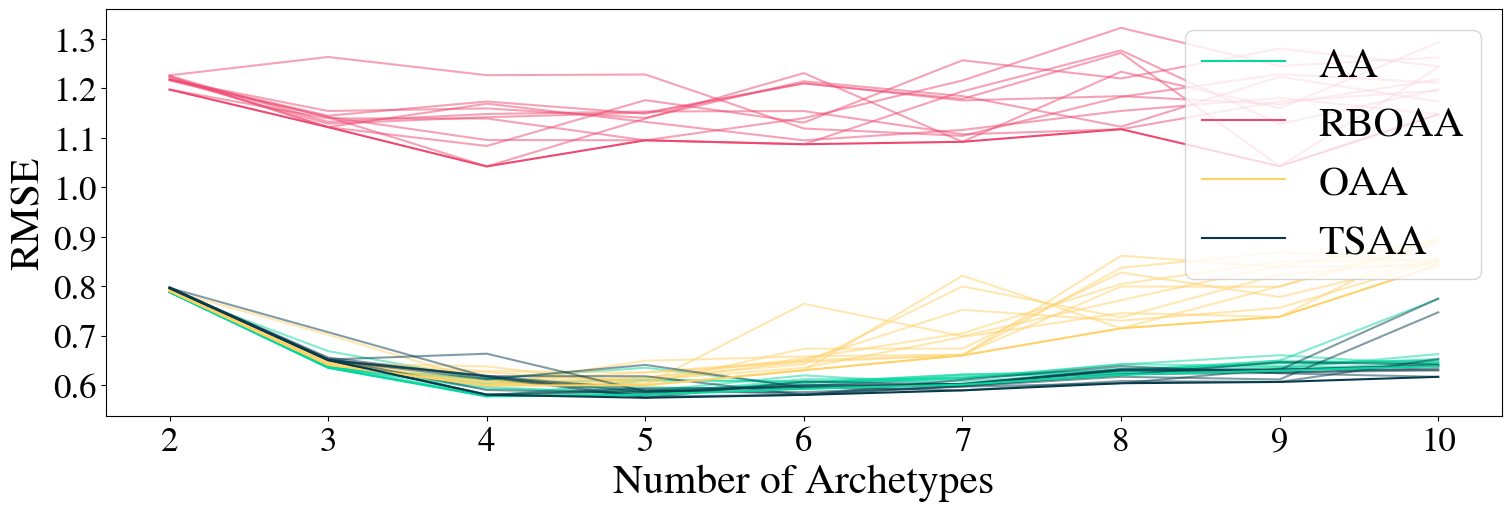

In [21]:
## Plot SSE

fig, ax = plt.subplots(1,1, figsize = (15,5), layout='constrained')
ax.plot(range(2,11), SSE_CAA[2:], c = my_pallette['AA'],alpha = 0.5)
ax.plot(range(2,11), SSE_RBOAA[2:],c = my_pallette['RBOAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_OAA[2:],c = my_pallette['OAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_TSOAA[2:],c = my_pallette['TSOAA'],alpha = 0.5)

ax.plot(range(2,11), np.min(SSE_CAA[2:],axis = 1), c = my_pallette['AA'],label = 'AA')
ax.plot(range(2,11), np.min(SSE_RBOAA[2:],axis = 1),c =  my_pallette['RBOAA'],label = 'RBOAA')
ax.plot(range(2,11), np.min(SSE_OAA[2:],axis = 1),c =  my_pallette['OAA'],label = 'OAA')
ax.plot(range(2,11), np.min(SSE_TSOAA[2:],axis = 1),c =  my_pallette['TSOAA'],label = 'TSAA')


ax.set_xlabel("Number of Archetypes", fontsize = 30)
ax.set_ylabel("RMSE", fontsize = 30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc='upper right',fontsize = 30)

plt.savefig("Plots_for_paper/CorruptionError_complex.png",dpi=1000)

In [ ]:
"#9055A2"

In [59]:
from src.visualizations.functions import get_alphas_from_betas, hex_to_rgb, darken_color
import seaborn as sns


def response_bias_plot(X, RBOAA_betas, OAA_betas, synthetic_betas=None):
    """
    X: M x N sized array
    RBOAA_betas: N x p+1 array
    OAA_betas: p+1 array
    synthetic betas p+1 or N x p+1 array depending on if RB = False/True
    """
    r, g, b  = hex_to_rgb(my_pallette['OAA'])
    OAA_color = [darken_color(r, g, b,0.5)]

    alpha_OAA, alpha, synthetic_alphas = get_alphas_from_betas(X, RBOAA_betas, OAA_betas, synthetic_betas)

    fig, ax = plt.subplots(1,1, figsize = (5,15), layout='constrained')
    
    ### plot RBOAA betas
    if (synthetic_betas is not None) and (synthetic_betas.ndim > 1): # Synthetic analysis
        if synthetic_betas.ndim > 1:
            
            method_colors = {'RBOAA': my_pallette['RBOAA'], 'Ground truth': my_pallette['GT']}
            df1 = pd.DataFrame(synthetic_alphas, columns=[f'{i}' for i in range(1,6)])
            df2 = pd.DataFrame(alpha, columns=[f'{i}' for i in range(1,6)])

            df1.loc[:, 'Method'] = 'Ground truth'
            df2.loc[:, 'Method'] = 'RBOAA'

            df1 = df1.melt(id_vars='Method', var_name='Point', value_name='alpha')
            df2 = df2.melt(id_vars='Method', var_name='Point', value_name='alpha')
            df = pd.concat([df1, df2])

            sns.boxplot(x='Point', y="alpha", hue="Method", showmeans=False, data=df, 
                        palette=method_colors,vert=False, meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "black"})
            
    else: # Real data
        medianprops = dict(linewidth=2.5, color=my_pallette['RBOAA'])
        rboaa_res = ax.boxplot(alpha,vert=False, medianprops=medianprops)
        # plot ground truth
        if synthetic_betas is not None:
            gt_res = ax.scatter(y= ax.get_yticks(), x=synthetic_alphas, marker='X',s=170, color=my_pallette['GT'], label = 'Ground truth')
    
    oaa_res = ax.scatter(y= ax.get_yticks(), x=alpha_OAA,marker='X',s=170, color = OAA_color,label = 'OAA', zorder=10)
    ax.xaxis.grid(True, which='major')
    [ax.axhline(x+.5,color='k') for x in ax.get_yticks()]
        
    # print(df.Answer)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)    
    ax.set_ylabel('Point on likert scale', fontsize=30)
    ax.set_xlabel(r'$\alpha$', fontsize=30)
    #ax.set_ylabel(r"$\alpha$", fontsize=30)

    # likert_text = ['1. very much like me', '2. like me', '3. somewhat like me', '4. A little like me', '5. Not like me', '6. Not like me at all']
    
    #ax.set_xticklabels(likert_text, rotation = 15)
    ax.set_xlim([-0.01,1.05])

    
    dummy_boxplot_rboaa = plt.Line2D([0], [0], linestyle='-', color=my_pallette['RBOAA'], linewidth=2.5)
    dummy_boxplot_gt = plt.Line2D([0], [0], linestyle='-', color=my_pallette['GT'], linewidth=2.5)
    
    if synthetic_betas is not None:
        ax.legend([oaa_res, dummy_boxplot_rboaa, dummy_boxplot_gt], ['OAA', 'RBOAA', 'Ground truth'], fontsize=30, loc='upper left')
    else:
        ax.legend([oaa_res, dummy_boxplot_rboaa], ['OAA', 'RBOAA'], fontsize=30, loc='upper left')

    #plt.savefig("Plots_for_paper/RB_Complex.png",dpi=1000)
    plt.show()


In [60]:
RBOAA_betas = complex_res['RBOAA']['K3'][2].b
OAA_betas = complex_res['OAA']['K3'][2].b


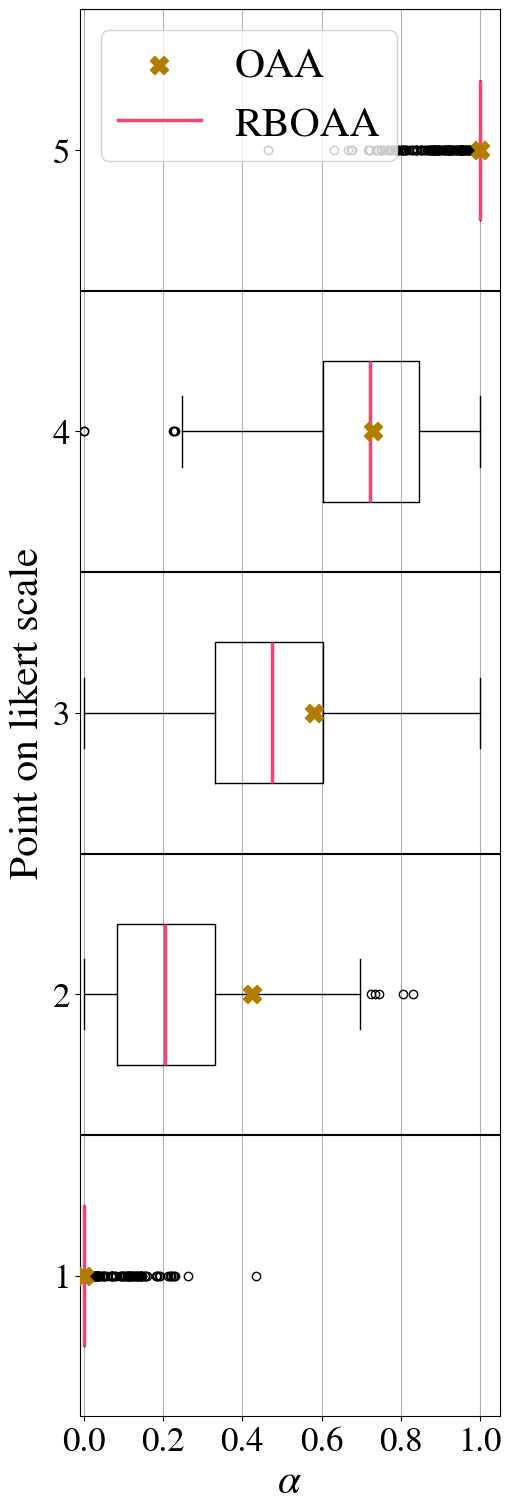

In [61]:
response_bias_plot(X, RBOAA_betas, OAA_betas, synthetic_betas=None)